In [1]:
import cv2 as cv
import numpy as np
from queue import PriorityQueue
import heapq
import matplotlib.pyplot as plt
import sys
import os

In [2]:
img1 = cv.imread("img1.jpg")
img2 = cv.imread("img2.jpg")

This function helps us to convert images from any size to the size that we want the image to be devisible on 

In [3]:
def resize_image(img, num=8):
    # Get the original image size
    height, width, _ = img.shape

    # Calculate new dimensions that are divisible by num
    new_height = (height // num) * num
    new_width = (width // num) * num

    # Resize the image using OpenCV's resize function
    resized_img = cv.resize(img, (new_width, new_height))

    return resized_img

- Color space conversion from BGR to YCbCr :

In [4]:
img1_ycbcr = cv.cvtColor(img1, cv.COLOR_BGR2YCrCb)
img2_ycbcr = cv.cvtColor(img2, cv.COLOR_BGR2YCrCb)

- Normalization step is by subtracting 127 from each element of every chanel :

In [5]:
normal_img1 = img1_ycbcr - (127,127,127)
normal_img2 = img2_ycbcr - (127,127,127)

- Deviding the image into smaller blocks that each block contains 8*8 pixels :

This function gets an image and then devide it into smaller peaces 

In [6]:
def divide_image_into_blocks(image):
    # Get dimensions of the image
    num_rows, num_cols = image.shape[:2]
    
    # Calculate number of blocks in each direction
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8
    
    # Create empty list to hold blocks
    blocks = []
    
    # Iterate over each block
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # Calculate starting and ending indices for this block
            start_x = x * 8
            end_x = start_x + 8
            
            start_y = y * 8
            end_y = start_y + 8
            
            # Extract block from image
            block = image[start_y:end_y, start_x:end_x]
            
            # Add block to list of blocks
            blocks.append(block)
    
    return blocks

And this is it inverse which we need at the end to convert blocks back to image 

In [7]:
def reconstruct_image_from_blocks(blocks, image_shape):
    # Get dimensions of the image
    num_rows, num_cols = image_shape[:2]
    
    # Calculate number of blocks in each direction
    num_blocks_x = num_cols // 8
    num_blocks_y = num_rows // 8
    
    # Create empty array to hold image
    image = np.zeros(image_shape, dtype=np.uint8)
    
    # Iterate over each block
    block_index = 0
    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            # Calculate starting and ending indices for this block
            start_x = x * 8
            end_x = start_x + 8
            
            start_y = y * 8
            end_y = start_y + 8
            
            # Extract block from list of blocks
            block = blocks[block_index]
            block_index += 1
            
            # Insert block into image
            image[start_y:end_y, start_x:end_x] = block
    
    return image

In [8]:
img1_blocks = divide_image_into_blocks(normal_img1)
img2_blocks = divide_image_into_blocks(normal_img2)

- Applying DCT on the small images :

This function takes list of blocks and then returns list of discret cosin transform of each blcok of image 

In [9]:
def apply_dct(blocks):
    dcts = []
    for block in blocks:
        dct = np.stack([cv.dct(np.float32(block[:,:,i])) for i in range(block.shape[2])], axis=2)
        dcts.append(dct)
    return dcts

Inverse of DCT implemented because we need to convert the image back to normal Thus we must have this 

In [10]:
def inverse_dct(dct_blocks):
    blocks = []
    for dct_block in dct_blocks:
        block = np.stack([cv.idct(np.float32(dct_block[:,:,i])) for i in range(dct_block.shape[2])], axis=2)
        blocks.append(block)
    return blocks

In [11]:
img1_dcts = apply_dct(img1_blocks)
img2_dcts = apply_dct(img2_blocks)

- Applying Frequency quantization on DCT coefficients and we can control how lossie we want this quantization to be using lossie argument :

In [12]:
def quantize(blocks, lossie=1):
    quantization_table = lossie * np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])
    quantized = []
    for block in blocks:
        dct_quantized = np.stack([np.round(block[:,:,i] / quantization_table) for i in range(block.shape[2])], axis=2)
        quantized.append(dct_quantized)
    return quantized, quantization_table

In [13]:
def dequantize(quantized_blocks, quantization_table):
    blocks = []
    for quantized_block in quantized_blocks:
        dct_dequantized = np.stack([np.round(quantized_block[:,:,i] * quantization_table) for i in range(quantized_block.shape[2])], axis=2)
        blocks.append(dct_dequantized)
    return blocks

In [14]:
img1_qu, quantization_table = quantize(img1_dcts)
img2_qu, quantization_table = quantize(img2_dcts)

- Using zigzag scan to map the 8x8 matrix to a 1x64 matrix

In [15]:
def zigzag_scan(blocks):
    zigzag_order = np.array([
    [ 0,  1,  5,  6, 14, 15, 27, 28],
    [ 2,  4,  7, 13, 16, 26, 29, 42],
    [ 3,  8, 12, 17, 25, 30, 41, 43],
    [ 9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]])

    ordered_blocks = []
    flatten_orders = zigzag_order.flatten()
    for block in blocks:
        y, cb, cr = block[:,:,0].flatten(), block[:,:,1].flatten(), block[:,:,2].flatten()
        y_ordered = y[flatten_orders]
        cb_ordered = cb[flatten_orders]
        cr_ordered = cr[flatten_orders]
        ordered_blocks.append(np.stack([y_ordered,cb_ordered, cr_ordered,], axis=1))
    return ordered_blocks

In [16]:
def inverse_zigzag_scan(ordered_blocks):
    zigzag_order = np.array([
        [ 0,  1,  5,  6, 14, 15, 27, 28],
        [ 2,  4,  7, 13, 16, 26, 29, 42],
        [ 3,  8, 12, 17, 25, 30, 41, 43],
        [ 9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]])

    blocks = []
    flatten_orders = zigzag_order.flatten()
    for ordered_block in ordered_blocks:
        y_ordered, cb_ordered, cr_ordered = ordered_block[:,0], ordered_block[:,1], ordered_block[:,2]
        y = np.zeros((64,))
        cb = np.zeros((64,))
        cr = np.zeros((64,))
        y[flatten_orders] = y_ordered
        cb[flatten_orders] = cb_ordered
        cr[flatten_orders] = cr_ordered
        y = np.reshape(y, (8, 8))
        cb = np.reshape(cb, (8, 8))
        cr = np.reshape(cr, (8, 8))
        block = np.stack([y, cb, cr], axis=2)
        blocks.append(block)
    return blocks

In [17]:
img1_zig = zigzag_scan(img1_dcts)
img2_zig = zigzag_scan(img2_dcts)

- Coding these coefficients

This huffman_encode is using the original approach of huffman coding to encode each block on their own and then huffman_decode method is used to decode each block back to normal if needed 

In [50]:
import heapq
from collections import defaultdict

def huffman_encode(arr):
    # Count the frequency of each integer in the array.
    freq = defaultdict(int)
    for num in arr:
        freq[num] += 1
    
    # Build a Huffman tree from the frequencies.
    heap = [[wt, [sym, ""]] for sym, wt in freq.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    
    # Generate the Huffman codes for each integer.
    huffman_codes = dict(heapq.heappop(heap)[1:])
    
    # Encode the array using the Huffman codes.
    encoded_arr = ""
    for num in arr:
        encoded_arr += huffman_codes[num]
    
    return encoded_arr, huffman_codes

def huffman_decode(encoded_arr, huffman_codes):
    # Invert the Huffman codes dictionary.
    inv_huffman_codes = {v: k for k, v in huffman_codes.items()}
    if encoded_arr == "":
        return np.zeros(64)
    # Decode the array using the inverted Huffman codes.
    decoded_arr = []
    code = ""
    for bit in encoded_arr:
        code += bit
        if code in inv_huffman_codes:
            decoded_arr.append(inv_huffman_codes[code])
            code = ""
    
    return np.array(decoded_arr)


This code encode the each of three chanels seperately from the other 

In [51]:
def huffman_encode_matrix(matrix):
    # Initialize list to store encoded data for each channel
    encoded_channels = []
    code_dicts = []
    # Loop through each channel in the matrix
    for i in range(matrix.shape[1]):
        # Extract the channel as a 1D array
        arr = matrix[:,i]

        # Encode the input data using Huffman coding
        encoded_arr, code_dict = huffman_encode(arr)

        # Append the encoded data and code dictionary to the list of encoded channels
        encoded_channels.append(encoded_arr)
        code_dicts.append(code_dict)
    
    return encoded_channels, code_dicts

def huffman_decode_matrix(encoded_channels, code_dicts):
    # Initialize matrix to store decoded data
    decoded_matrix = np.zeros((64, len(encoded_channels)), dtype=np.uint8)

    # Loop through each channel in the encoded data
    for i in range(len(encoded_channels)):
        # Decode the encoded data using the generated code dictionary
        decoded_arr = huffman_decode(encoded_channels[i], code_dicts[i])
        
        # Set the decoded channel in the matrix
        decoded_matrix[:,i] = decoded_arr

    return decoded_matrix

And this code tries to encode all blocks together using previous methods i implemented earlier 

In [59]:
def encode(blocks):
    list_encode_channels, list_code_dicts = [],[]
    for block in blocks :
        encoded_channels, code_dict = huffman_encode_matrix(block)
        list_encode_channels.append(encoded_channels)
        list_code_dicts.append(code_dict)
    return list_encode_channels, list_code_dicts

def decode(list_encode_channels, list_code_dict):
    decoded_blocks = []

    for encoded_channels, code_dict in zip(list_encode_channels, list_code_dict):
        
        block = huffman_decode_matrix(encoded_channels, code_dict)
        decoded_blocks.append(block)
        
    return decoded_blocks


In [ ]:
encode_channels_1, code_dict1 = encode(img1_zig)
encode_channels_2, code_dict2  = encode(img2_zig)

In [ ]:
compressed_size_img1 = sys.getsizeof(encode_channels_1) + sys.getsizeof(code_dict1)
compressed_size_img2 = sys.getsizeof(encode_channels_2) + sys.getsizeof(code_dict2)
img1_size = sys.getsizeof(img1)
img2_size = sys.getsizeof(img2)

In [28]:
img1_compression_ratio = img1_size/compressed_size_img1
img2_compression_ratio = img2_size/compressed_size_img2
img1_redundancy_ratio = 1 - 1/(img1_compression_ratio)
img2_redundancy_ratio = 1 - 1/(img2_compression_ratio)

As we can see the result of this compression is good enough but its not over we must convert it back to the image to see how lossy our image are because of the parameter we set in quantization function for lossi argument 

In [29]:
print(f"Compression ratio of the first image using this approach is : {img1_compression_ratio} and its data redundancy is about {100* img1_redundancy_ratio} ")
print(f"Compression ratio of the second image using this approach is : {img2_compression_ratio} and its data redundancy is about {100* img2_redundancy_ratio} ")

Compression ratio of the first image using this approach is : 11.509577330524762 and its data redundancy is about 91.31158363784671 
Compression ratio of the second image using this approach is : 10.736116156217243 and its data redundancy is about 90.68564473922068 


decoding huffman form of blocks 

In [79]:
decoded1 = decode(encode_channels_1, code_dict1)
decoded2 = decode(encode_channels_2, code_dict2)

inverse the zigzag path and getting back each quantized blocks 

In [80]:
img1_inv_zig = inverse_zigzag_scan(decoded1)
img2_inv_zig = inverse_zigzag_scan(decoded2)

inverse the quantization to get back the DCT form of blocks 

In [81]:
img1_dq = dequantize(img1_inv_zig, quantization_table)
img2_dq = dequantize(img2_inv_zig, quantization_table)

inverse DCT and haveing the image in spatial domain 

In [82]:
img1_idct = inverse_dct(img1_dq)
img2_idct = inverse_dct(img2_dq)

Now just reconstruct the image and then getting back image from its 64 blocks 

In [83]:
img1_ = reconstruct_image_from_blocks(img1_idct, img1.shape)
img2_ = reconstruct_image_from_blocks(img2_idct, img2.shape)

shift intensities to where they were

In [84]:
img1_r_ycrcb = normal_img1 + (127,127,127)
img2_r_ycrcb = normal_img2 + (127,127,127)

In [90]:
img1_r_ycrcb = img1_r_ycrcb.astype(np.uint8)
img2_r_ycrcb = img2_r_ycrcb.astype(np.uint8)

Convert the image form YCrCb back to RGB 

In [91]:
img1_r = cv.cvtColor(img1_r_ycrcb, cv.COLOR_YCrCb2RGB)
img2_r = cv.cvtColor(img2_r_ycrcb, cv.COLOR_YCrCb2RGB)

As we can see this is the result of converting the image back to what it was and ther is not that much of chang in the original images 

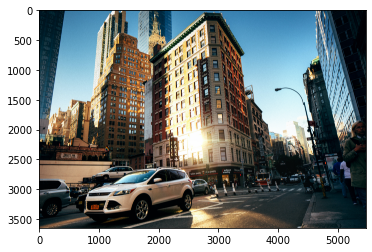

In [92]:
plt.imshow(img1_r)

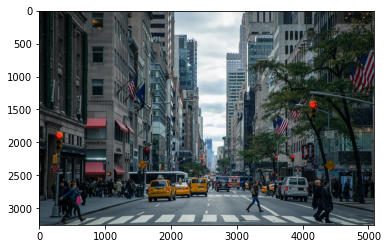

In [93]:
plt.imshow(img2_r)